In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import ast
from mpl_toolkits.axes_grid1 import ImageGrid
import math
from PIL import Image, ImageDraw, ImageColor
import numpy as np
import os
import random
import shutil
from tabulate import tabulate

# 0. Helper Functions

In [2]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
rico_path = "../data/rico/"

In [4]:
def copy_images_with_new_names(source_path, target_path, ids):
    os.makedirs(target_path, exist_ok=True)
    image_files = [f for f in os.listdir(source_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif'))]
    for new_id in ids:
        source_file = os.path.join(source_path, f"{new_id}.jpg")
        target_file = os.path.join(target_path, f"{new_id}.jpg")
        shutil.copyfile(source_file, target_file)
        print(f"Copied {source_file} to {target_file}")

# 1. Create Filtered CSV

In [5]:
all_guis = pd.read_csv("../data/all_guis.csv")
app_details = pd.read_csv(rico_path + "app_details.csv")
ui_details = pd.read_csv(rico_path + "ui_details.csv")

In [11]:
merged_details = pd.merge(ui_details, app_details[["App Package Name", "Average Rating", "Number of Ratings", "Number of Downloads"]], on="App Package Name")
merged_details.head()

,UI Number,App Package Name,Interaction Trace Number,UI Number in Trace,Average Rating,Number of Ratings,Number of Downloads
0,0,com.brc.PeriodTrackerDiary,0,15,4.600,8340,"100,000 - 500,000"
1,1,com.brc.PeriodTrackerDiary,0,531,4.600,8340,"100,000 - 500,000"
2,2,yong.app.videoeditor,0,221,3.400,100637,"5,000,000 - 10,000,000"
3,3,yong.app.videoeditor,0,1289,3.400,100637,"5,000,000 - 10,000,000"
4,4,yong.app.videoeditor,0,125,3.400,100637,"5,000,000 - 10,000,000"


In [12]:
all_guis.rename(columns={"id":"UI Number"}, inplace=True)

In [13]:
merged_guis = pd.merge(all_guis, merged_details[["UI Number", "App Package Name", "Average Rating", "Number of Ratings", "Number of Downloads"]], on="UI Number")
merged_guis.head()

,UI Number,data,App Package Name,Average Rating,Number of Ratings,Number of Downloads
0,0,"{'bg_color': '#FFFFFF', 'ui_comps': [{'ancesto...",com.brc.PeriodTrackerDiary,4.600,8340,"100,000 - 500,000"
1,1,"{'bg_color': '#F5F5F5', 'ui_comps': [{'ancesto...",com.brc.PeriodTrackerDiary,4.600,8340,"100,000 - 500,000"
2,2,"{'bg_color': '#FFFFFF', 'ui_comps': [{'iconCla...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000"
3,3,"{'bg_color': '#FEFEFE', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000"
4,4,"{'bg_color': '#FFFFFF', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000"


In [14]:
filters = pd.read_csv(rico_path + "filters_updated.csv")
filters.rename(columns={"number":"UI Number"}, inplace=True)
filters.head()

,Unnamed: 0,UI Number,menu,summary,similarity,similar_to,over_threshold
0,0,2,0,1,0.000,-1,0
1,1,3,0,1,0.317,2,0
2,2,4,0,1,0.832,3,0
3,3,5,0,0,0.851,4,0
4,4,6,0,1,0.899,4,0


In [15]:
merged_filtered = pd.merge(merged_guis, filters[["UI Number", "menu", "over_threshold"]], on="UI Number")
merged_filtered.head()

,UI Number,data,App Package Name,Average Rating,Number of Ratings,Number of Downloads,menu,over_threshold
0,2,"{'bg_color': '#FFFFFF', 'ui_comps': [{'iconCla...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0
1,3,"{'bg_color': '#FEFEFE', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0
2,4,"{'bg_color': '#FFFFFF', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0
3,5,"{'bg_color': '#FEFEFE', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0
4,6,"{'bg_color': '#FCFCFA', 'ui_comps': [{'text': ...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0


In [17]:
len(merged_filtered)

57764

In [18]:
merged_filtered = merged_filtered[(merged_filtered["menu"]==0) & (merged_filtered["over_threshold"]==0)].copy()

In [19]:
len(merged_filtered)

48401

In [20]:
merged_filtered.to_csv(rico_path + "filtered_guis.csv")

# 2. Add Statistics

In [21]:
merged_filtered = pd.read_csv(rico_path + "filtered_guis.csv")

In [22]:
types = ["Web View", "List Item", "Multi-Tab", "Input", "Text Button", "Slider", "Background Image", "Advertisement", "Card", "Bottom Navigation", 
         "Modal", "On/Off Switch", "Button Bar", "Number Stepper", "Text", "Map View", "Checkbox", "Date Picker", "Image", "Drawer", "Radio Button", 
         "Video", "Toolbar", "Pager Indicator", "Icon", "Layout"]

In [23]:
merged_filtered["num_comps"] = 0
merged_filtered["num_groups"] = 0
for type in types:
    merged_filtered[type] = 0
merged_filtered.head()

,Unnamed: 0,UI Number,data,App Package Name,Average Rating,Number of Ratings,Number of Downloads,menu,over_threshold,num_comps,...,Checkbox,Date Picker,Image,Drawer,Radio Button,Video,Toolbar,Pager Indicator,Icon,Layout
0,0,2,"{'bg_color': '#FFFFFF', 'ui_comps': [{'iconCla...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,3,"{'bg_color': '#FEFEFE', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2,4,"{'bg_color': '#FFFFFF', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,3,5,"{'bg_color': '#FEFEFE', 'ui_comps': [{'ancesto...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,4,6,"{'bg_color': '#FCFCFA', 'ui_comps': [{'text': ...",yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
for index, row in merged_filtered.iterrows():
    gui = ast.literal_eval(row["data"])
    merged_filtered.at[index, "num_groups"] = len(gui["ui_comp_groups"])
    for group in gui["ui_comp_groups"]:
        type = group.get("componentLabel")
        if type is not None:
            #print(type)
            merged_filtered.at[index, type] += 1
    merged_filtered.at[index, "num_comps"] = len(gui["ui_comps"])
    for comp in gui["ui_comps"]:
        type = comp.get("componentLabel")
        if type is not None:
            #print(type)
            merged_filtered.at[index, type] += 1
merged_filtered.head()

In [25]:
merged_filtered.to_csv(rico_path + "filtered_guis_with_stats.csv", index=False)

In [ ]:
merged_filtered = pd.read_csv(rico_path + "filtered_guis_with_stats.csv")

In [27]:
merged_filtered.drop(columns=["data"]).head()

,Unnamed: 0,UI Number,App Package Name,Average Rating,Number of Ratings,Number of Downloads,menu,over_threshold,num_comps,num_groups,...,Checkbox,Date Picker,Image,Drawer,Radio Button,Video,Toolbar,Pager Indicator,Icon,Layout
0,0,2,yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,5,1,...,0,0,0,0,0,0,0,0,2,0
1,1,3,yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,6,1,...,0,0,2,0,0,1,1,0,1,0
2,2,4,yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,19,6,...,0,0,4,0,0,0,1,0,4,0
3,3,5,yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,9,1,...,0,0,1,0,0,1,1,0,3,0
4,4,6,yong.app.videoeditor,3.400,100637,"5,000,000 - 10,000,000",0,0,21,17,...,0,0,5,0,0,0,1,0,4,16


In [28]:
merged_filtered.drop(columns=["data"]).to_csv(rico_path + "filters_and_stats.csv", index=False)

In [29]:
def show_images(ranked, img_path):
    fig = plt.figure(figsize=(15,15)) # specifying the overall grid size
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                 nrows_ncols=(int(math.ceil(len(ranked)/3)),3),
                 axes_pad=0.3,  share_all=True
                 )
    for ax, rank in zip(grid, ranked):
        rico_id = rank
        img = Image.open(img_path + str(rico_id) + ".jpg")
        img = img.resize((1080, 1920))
        ax.imshow(np.array(img))
        ax.grid(False)
        title = str(rico_id)
        ax.title.set_text(title)

    plt.show()

In [ ]:
rico_stats = pd.read_csv("../data/rico/filters_and_stats.csv")

In [33]:
included_columns = ['Web View', 'List Item', 'Multi-Tab', 'Input', 'Text Button', 'Slider', 'Background Image', 
                    'Advertisement', 'Card', 'Bottom Navigation', 'Modal', 'On/Off Switch', 'Button Bar', 'Number Stepper', 
                    'Text', 'Map View', 'Checkbox', 'Date Picker', 'Image', 'Drawer', 'Radio Button', 'Video', 'Toolbar', 
                    'Pager Indicator', 'Icon', 'Layout']

def count_positive(row):
    return sum(1 for col in included_columns if row[col] > 0)

rico_stats['num_unique_comps'] = rico_stats.apply(lambda row: count_positive(row), axis=1)

In [34]:
included_columns_updated = ['Web View', 'Input', 'Text Button', 'Slider', 'Background Image', 'Advertisement', 'On/Off Switch', 
                            'Number Stepper', 'Text', 'Map View', 'Checkbox', 'Date Picker', 'Image', 'Radio Button', 'Video',
                            'Pager Indicator', 'Icon']

def count_positive_updated(row):
    return sum(1 for col in included_columns_updated if row[col] > 0)

rico_stats['num_unique_comps_upd'] = rico_stats.apply(lambda row: count_positive_updated(row), axis=1)

In [35]:
def parse_str(ratings):
    try:
        return int(ratings)
    except:
        return 0

In [36]:
rico_stats['Number of Ratings'] = rico_stats['Number of Ratings'].apply(lambda x:parse_str(x))
rico_stats['Number of Downloads'] = rico_stats['Number of Downloads'].apply(lambda x: int(x.split('-')[0].strip().replace(',','')) if 'January 10, 2015' not in x else 0)

In [47]:
num_comps_ranges = [2,3,4,5,8,10,15,20,25,30]
num_uniq_comps_ranges = [1,2,3,4,5,6,7,8,9]

In [48]:
result_table = []
for num_comps in num_comps_ranges:
    num_comp_row = ['#comps: '+str(num_comps)]
    for num_uniq_comps in num_uniq_comps_ranges:
        num_comp_row.append(str(len(rico_stats[(rico_stats['num_comps']>=num_comps) & (rico_stats['num_unique_comps']>=num_uniq_comps)])))
    result_table.append(num_comp_row)

In [49]:
header = ['#c/#u']
header.extend(["#uniq: "+str(rang) for rang in num_uniq_comps_ranges])
tabulated_table = tabulate(tabular_data=result_table, headers=header)
print(tabulated_table)

#c/#u         #uniq: 1    #uniq: 2    #uniq: 3    #uniq: 4    #uniq: 5    #uniq: 6    #uniq: 7    #uniq: 8    #uniq: 9
----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------  ----------
#comps: 2        47898       47678       45623       40629       32441       21950       12063        4785        1223
#comps: 3        47029       46925       45472       40628       32441       21950       12063        4785        1223
#comps: 4        45003       44923       43797       39842       32431       21950       12063        4785        1223
#comps: 5        42680       42616       41645       38431       32014       21902       12062        4785        1223
#comps: 8        33414       33372       32817       30984       27529       20382       11752        4757        1222
#comps: 10       28505       28476       28085       26664       24234       18473       11157        4657        1212
#comps: 15       19050       19046       18961  

11958


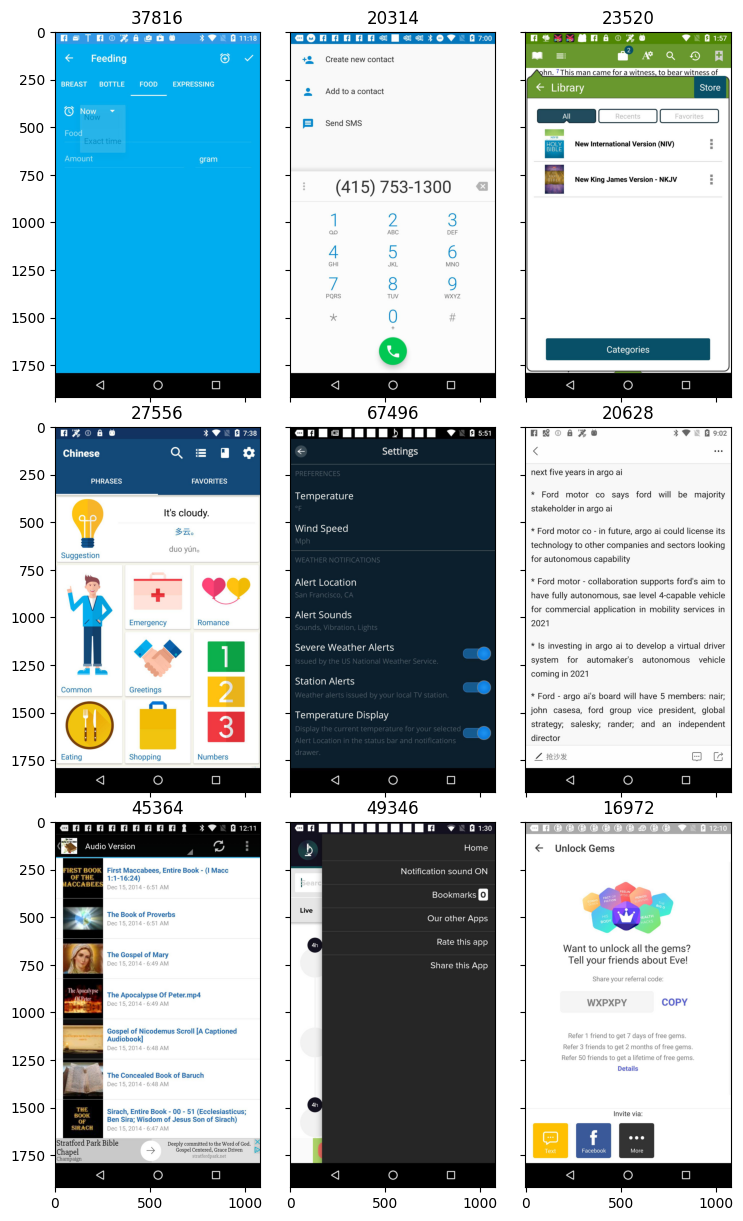

In [54]:
filtered_ids = rico_stats[((rico_stats['num_comps']>=7) & (rico_stats['num_unique_comps']>=7))]
print(len(filtered_ids))
filtered_ids=filtered_ids.sample(9)['UI Number'].values.tolist()
show_images(filtered_ids, rico_path+"/unique_uis/combined/")

11958


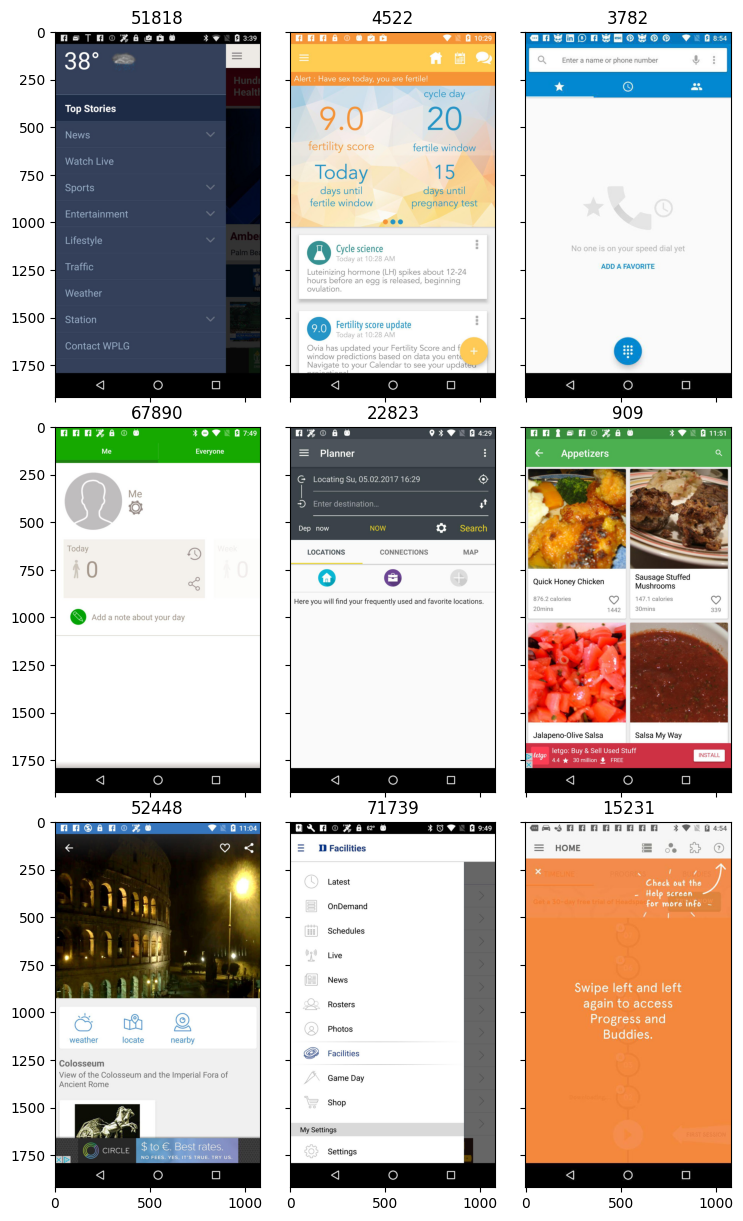

In [60]:
filtered_ids = rico_stats[((rico_stats['num_comps']>=7) & (rico_stats['num_unique_comps']>=7))]
print(len(filtered_ids))
filtered_ids=filtered_ids.sample(9)['UI Number'].values.tolist()
show_images(filtered_ids, rico_path+"/unique_uis/combined/")

In [63]:
copy_images_with_new_names(rico_path+'unique_uis/combined/', '../data/sampled_data/', filtered_ids)

Copied ../data/rico/unique_uis/combined/61735.jpg to ../data/sampled_data/61735.jpg
Copied ../data/rico/unique_uis/combined/173.jpg to ../data/sampled_data/173.jpg
Copied ../data/rico/unique_uis/combined/8488.jpg to ../data/sampled_data/8488.jpg
Copied ../data/rico/unique_uis/combined/52.jpg to ../data/sampled_data/52.jpg
Copied ../data/rico/unique_uis/combined/41418.jpg to ../data/sampled_data/41418.jpg
Copied ../data/rico/unique_uis/combined/9732.jpg to ../data/sampled_data/9732.jpg
Copied ../data/rico/unique_uis/combined/70043.jpg to ../data/sampled_data/70043.jpg
Copied ../data/rico/unique_uis/combined/8533.jpg to ../data/sampled_data/8533.jpg
Copied ../data/rico/unique_uis/combined/37414.jpg to ../data/sampled_data/37414.jpg


# 3. Random Sample From Rico

In [ ]:
filtered_ids = rico_stats[((rico_stats['num_comps']>=7) & (rico_stats['num_unique_comps']>=7))]
print(len(filtered_ids))
filtered_ids=filtered_ids.sample(1000, random_state=42)['UI Number'].values.tolist()

In [46]:
sorted_filtered_ids = sorted(filtered_ids)

In [66]:
copy_images_with_new_names(rico_path+'unique_uis/combined/', '../data/sampled_data/', sorted_filtered_ids[:50])

Copied ../data/rico/unique_uis/combined/121.jpg to ../data/sampled_data/121.jpg
Copied ../data/rico/unique_uis/combined/144.jpg to ../data/sampled_data/144.jpg
Copied ../data/rico/unique_uis/combined/205.jpg to ../data/sampled_data/205.jpg
Copied ../data/rico/unique_uis/combined/217.jpg to ../data/sampled_data/217.jpg
Copied ../data/rico/unique_uis/combined/222.jpg to ../data/sampled_data/222.jpg
Copied ../data/rico/unique_uis/combined/279.jpg to ../data/sampled_data/279.jpg
Copied ../data/rico/unique_uis/combined/298.jpg to ../data/sampled_data/298.jpg
Copied ../data/rico/unique_uis/combined/476.jpg to ../data/sampled_data/476.jpg
Copied ../data/rico/unique_uis/combined/629.jpg to ../data/sampled_data/629.jpg
Copied ../data/rico/unique_uis/combined/706.jpg to ../data/sampled_data/706.jpg
Copied ../data/rico/unique_uis/combined/709.jpg to ../data/sampled_data/709.jpg
Copied ../data/rico/unique_uis/combined/721.jpg to ../data/sampled_data/721.jpg
Copied ../data/rico/unique_uis/combined/

In [70]:
df_final_sample = pd.DataFrame(sorted_filtered_final_sample, columns=['Rico ID'])

In [86]:
df_final_sample_350.to_csv('../data/sampled_data/final_sample.csv')

In [ ]:
copy_images_with_new_names(rico_path+'unique_uis/combined/', '../data/sampled_data/final_sample', df_final_sample_350['Rico ID'].values.tolist())

# 4. Analyze Rico GUI Annotations

In [134]:
annotations_1 = pd.read_csv("../data/sample_annotations/final/final_sample_annotation_1.csv", sep=';')
annotations_1.columns = [f"{col}_1" for col in annotations_1.columns]

annotations_2 = pd.read_csv("../data/sample_annotations/final/final_sample_annotation_2.csv", sep=';')
annotations_2.columns = [f"{col}_2" for col in annotations_2.columns]

annotations_3 = pd.read_csv("../data/sample_annotations/final/final_sample_annotation_3.csv", sep=';')
annotations_3.columns = [f"{col}_3" for col in annotations_3.columns]

In [138]:
annotations_merged = pd.concat([annotations_1, annotations_2, annotations_3], axis=1)

In [140]:
# Filter by not safe for work
annotations_merged_filtered = annotations_merged[(annotations_merged['NSFW_1'] == 'No') & (annotations_merged['NSFW_2'] == 'No') & (annotations_merged['NSFW_3'] == 'No')]

In [141]:
len(annotations_merged_filtered)

323

In [142]:
# Filter by not safe for work
annotations_nsfw = annotations_merged[(annotations_merged['NSFW_1'] == 'Yes') | (annotations_merged['NSFW_2'] == 'Yes') | (annotations_merged['NSFW_3'] == 'Yes')]

In [143]:
len(annotations_nsfw)

27

In [147]:
# Delete 29323 since 29356 is almost the same
annotations_merged_filtered = annotations_merged_filtered[~(annotations_merged_filtered['Rico ID_1'] == 29323)]

In [148]:
len(annotations_merged_filtered)

322

In [149]:
annotations_include = annotations_merged_filtered[['Rico ID_1', 'Include_1', 'Include_2', 'Include_3']].copy()

In [151]:
from collections import Counter

In [152]:
annotations_include['majority_vote_min'] = annotations_include.apply(lambda row: 'Yes' if Counter([row['Include_1'], row['Include_2'], row['Include_3']])['Yes'] >= 2 else 'No', axis=1)
annotations_include['majority_vote_max'] = annotations_include.apply(lambda row: 'Yes' if Counter([row['Include_1'], row['Include_2'], row['Include_3']])['Yes'] == 3 else 'No', axis=1)

In [158]:
annotations_include[annotations_include['majority_vote_min'] == 'Yes']

,Rico ID_1,Include_1,Include_2,Include_3,majority_vote_min,majority_vote_max
2,3790,Yes,Yes,Yes,Yes,Yes
3,4003,Yes,No,Yes,Yes,No
6,4328,Yes,Yes,Yes,Yes,Yes
9,6011,Yes,Yes,No,Yes,No
12,6705,Yes,Yes,Yes,Yes,Yes
...,...,...,...,...,...,...
336,69817,Yes,Yes,No,Yes,No
337,69932,Yes,Yes,No,Yes,No
341,71153,Yes,Yes,No,Yes,No
347,71954,Yes,Yes,Yes,Yes,Yes


In [159]:
selected_rico_guis = annotations_include[annotations_include['majority_vote_min'] == 'Yes']['Rico ID_1'].values.tolist()

In [ ]:
copy_images_with_new_names(rico_path+'unique_uis/combined/', '../data/sample_annotations/final/selected_rico_guis/', selected_rico_guis)

In [161]:
url_base = 'base_url'

In [162]:
all_urls = [url_base + str(rico_id) + '.jpg' for rico_id in selected_rico_guis]